Convolutional Neural Network to classify flower images

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from keras import layers

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
RGB = 3
EPOCHS = 30

Dataset loading

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='flowers',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 8009 files belonging to 8 classes.


In [5]:
class_names = dataset.class_names
class_names

['bellflower',
 'common_daisy',
 'dandelion',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

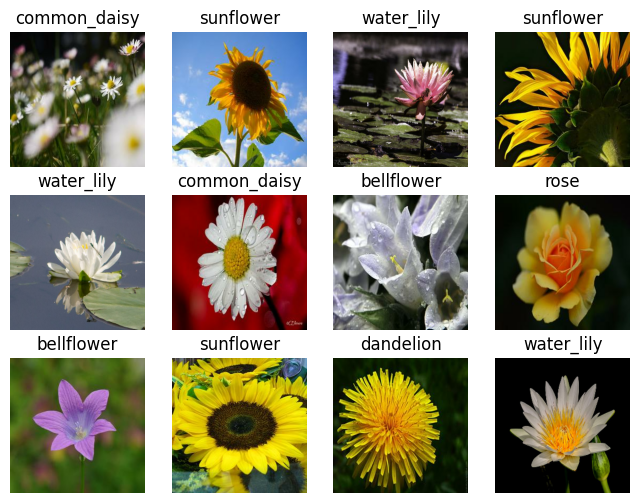

In [6]:
plt.figure(figsize=(8,6))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Separate train, validation and test sets

In [10]:
def dataset_separation(ds, train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = dataset_separation(dataset)

In [12]:
len(train_ds)

200

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, RGB)
num_classes = 8
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
200/200 [==============================] - 235s 1s/step - loss: 1.3874 - accuracy: 0.5169 - val_loss: 1.0098 - val_accuracy: 0.6575
Epoch 2/30
200/200 [==============================] - 214s 1s/step - loss: 0.9872 - accuracy: 0.6570 - val_loss: 0.9549 - val_accuracy: 0.6837
Epoch 3/30
200/200 [==============================] - 206s 1s/step - loss: 0.8899 - accuracy: 0.6926 - val_loss: 0.7817 - val_accuracy: 0.7312
Epoch 4/30
200/200 [==============================] - 200s 1s/step - loss: 0.8417 - accuracy: 0.7071 - val_loss: 0.6871 - val_accuracy: 0.7713
Epoch 5/30
200/200 [==============================] - 198s 991ms/step - loss: 0.7713 - accuracy: 0.7372 - val_loss: 0.6960 - val_accuracy: 0.7538
Epoch 6/30
200/200 [==============================] - 198s 988ms/step - loss: 0.7287 - accuracy: 0.7485 - val_loss: 0.5955 - val_accuracy: 0.8012
Epoch 7/30
200/200 [==============================] - 199s 996ms/step - loss: 0.6925 - accuracy: 0.7616 - val_loss: 0.5463 - val_accurac

In [24]:
scores = model.evaluate(test_ds)

26/26 [==============================] - 19s 273ms/step - loss: 0.6792 - accuracy: 0.8149


In [25]:
history.history['accuracy']

[0.5168574452400208,
 0.657048761844635,
 0.6926454305648804,
 0.7070723176002502,
 0.7371804714202881,
 0.7484710812568665,
 0.7616434097290039,
 0.7762270569801331,
 0.7842245697975159,
 0.8042966723442078,
 0.8058648109436035,
 0.8127646446228027,
 0.8231143355369568,
 0.8336208462715149,
 0.8413046598434448,
 0.8444409370422363,
 0.8463227152824402,
 0.8591814041137695,
 0.8596518635749817,
 0.8615336418151855,
 0.8687470555305481,
 0.8665516972541809,
 0.8779990673065186,
 0.8678061962127686,
 0.878783106803894,
 0.8800376057624817,
 0.8894464373588562,
 0.8817625641822815,
 0.8880351185798645,
 0.8946213126182556]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validating Accuracy')

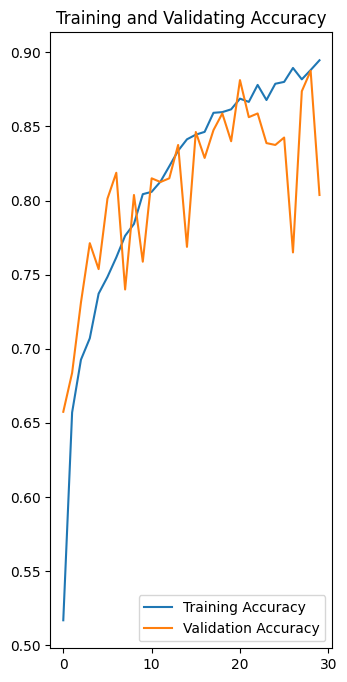

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training and Validating Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

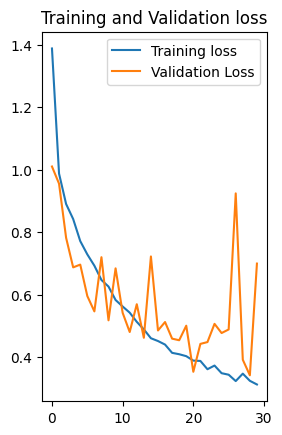

In [28]:
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 72ms/step


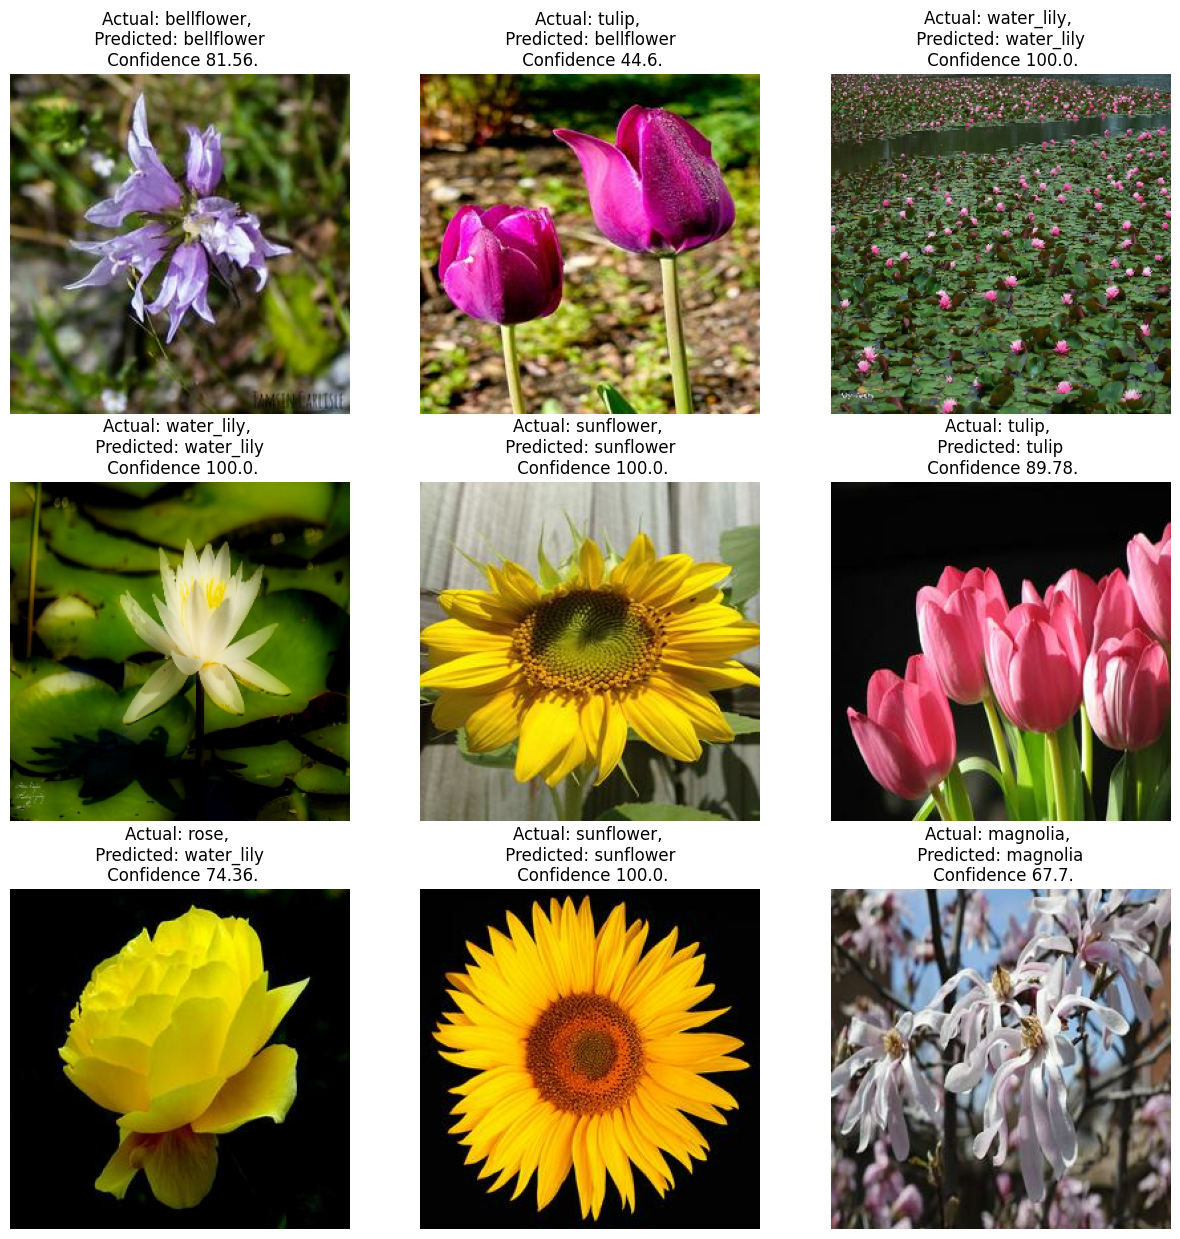

In [31]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence {confidence}.")

        plt.axis("off")